In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Project inspired from this paper
**<a href= "https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment"> DeepFood</a>**

In [5]:
import tensorflow as tf

### Get helper functions

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-19 15:50:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-19 15:50:54 (69.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Tensoflow Datasets

In [8]:
import tensorflow_datasets as tfds

In [9]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteWPGP2V/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteWPGP2V/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 dataset

In [12]:
train_one_sample = train_data.take(1)

In [13]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


In [16]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 12,  13,   7],
        [ 12,  13,   7],
        [ 13,  14,   8],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[ 12,  13,   7],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[  7,   8,   2],
        [  7,   8,   2],
        [  7,   8,   2],
        ...,
        [ 22,  12,   2],
        [ 21,  11,   1],
        [ 20,  10,   0]],

       ...,

       [[188, 191, 184],
        [188, 191, 184],
        [188, 191, 184],
        ...,
        [243, 248, 244],
        [243, 248, 244],
        [242, 247, 243]],

       [[187, 190, 183],
        [189, 192, 185],
        [190, 193, 186],
        ...,
        [241, 245, 244],
        [241, 245, 244],
        [241, 245, 244]],

       [[186, 189, 182],
        [189, 192, 185],
        [191, 194, 187],
        ...,
        [238, 242, 24

### Plot an image from tensorflow dataset

In [17]:
import matplotlib.pyplot as plt

(-0.5, 511.5, 511.5, -0.5)

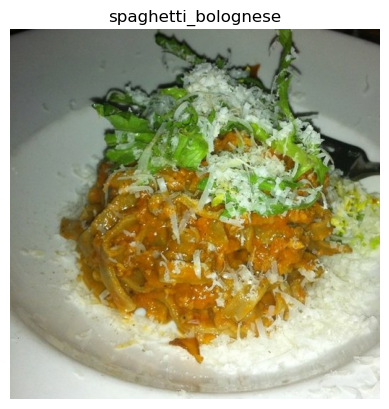

In [18]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

### Creating preprocessing functions

In [19]:
def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [20]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[12 13  7]
  [12 13  7]
  [13 14  8]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]

 [[12 13  7]
  [11 12  6]
  [11 12  6]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[11.586735   12.586735    6.586735  ]
  [11.714286   12.714286    6.714286  ]
  [ 8.857142    9.857142    4.8571424 ]
  ...
  [20.714308   11.142836    1.2857144 ]
  [20.668371   10.668372    0.        ]
  [21.         11.          0.        ]]

 [[ 2.3571415   3.3571415   0.1428566 ]
  [ 3.1530607   4.153061    0.07653028]
  [ 3.0561223   4.0561223   0.        ]
  ...
  [26.071407   18.071407    7.0714073 ]
  [24.785702   14.785702    4.7857018 ]
  [22.499966   12.499966    2.4999657 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


### Batch and Prepare datsets

In [21]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Create modelling callbacks

In [23]:
from helper_functions import create_tensorboard_callback

In [24]:
checkpoint_path = "model_checkpoints/cp.ckpt"

In [25]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_accuracy",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

### Setup mixed precision training

In [26]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Build feature extraction model

In [28]:
from tensorflow.keras import layers

In [29]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [30]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Fitting the extration model

In [32]:
history_0 = model.fit(train_data,
                     epochs=5,
                     validation_data=test_data,
                     validation_steps=int(0.15 * len(test_data)),
                     callbacks=[create_tensorboard_callback("training_logs", 
                                                            "efficientnetb0_101_classes_all_data_feature_extract"), 
                                model_checkpoint]) 

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230619-160252
Epoch 1/5
2368/2368 [==============================] - 207s 78ms/step - loss: 1.7182 - accuracy: 0.5824 - val_loss: 1.1288 - val_accuracy: 0.6973
Epoch 2/5
2368/2368 [==============================] - 183s 76ms/step - loss: 1.2000 - accuracy: 0.6889 - val_loss: 1.0275 - val_accuracy: 0.7211
Epoch 3/5
2368/2368 [==============================] - 181s 76ms/step - loss: 1.0538 - accuracy: 0.7239 - val_loss: 0.9888 - val_accuracy: 0.7283
Epoch 4/5
2368/2368 [==============================] - 178s 74ms/step - loss: 0.9596 - accuracy: 0.7475 - val_loss: 0.9790 - val_accuracy: 0.7288
Epoch 5/5
2368/2368 [==============================] - 186s 78ms/step - loss: 0.8897 - accuracy: 0.7655 - val_loss: 0.9705 - val_accuracy: 0.7309


In [33]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 54s 69ms/step - loss: 0.9798 - accuracy: 0.7318


[0.9798218011856079, 0.7318019866943359]

In [34]:
def create_model():
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape, name="input_layer")

    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = layers.Dense(len(class_names))(x)

    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [35]:
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

created_model.load_weights(checkpoint_path)

results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 56s 67ms/step - loss: 0.9798 - accuracy: 0.7318


In [36]:
# import numpy as np
# assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

### Saving model

In [37]:
# save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
# model.save(save_dir)

In [38]:
# loaded_saved_model = tf.keras.models.load_model(save_dir)

### Important callbaks

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_best_only=True,
                                                     monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.2,
                                                patience=2,
                                                verbose=1,
                                                min_lr=1e-7)

In [40]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

### Fine tuning

In [41]:
for layer in created_model.layers:
    layer.trainable = True

In [42]:
created_model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(0.0001),
                    metrics=["accuracy"])

In [43]:
finetune_history_0 = created_model.fit(train_data,
                                      epochs=100,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"),
#                                                 model_checkpoint,
                                                early_stopping,
                                                reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230619-162135
Epoch 1/100
2368/2368 [==============================] - 427s 154ms/step - loss: 0.7949 - accuracy: 0.7833 - val_loss: 0.7951 - val_accuracy: 0.7775 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 366s 153ms/step - loss: 0.4769 - accuracy: 0.8660 - val_loss: 0.7883 - val_accuracy: 0.7879 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 363s 152ms/step - loss: 0.2614 - accuracy: 0.9250 - val_loss: 0.8647 - val_accuracy: 0.7871 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9562
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 365s 153ms/step - loss: 0.1451 - accuracy: 0.9562 - val_loss: 1.0166 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 368s 15

In [44]:
results_fine_tuning = created_model.evaluate(test_data)
results_fine_tuning

790/790 [==============================] - 55s 69ms/step - loss: 1.0611 - accuracy: 0.7955


[1.0610694885253906, 0.7954851388931274]

### Fine tuning last 20 layers of base model

In [46]:
model_last_20 = create_model() 

In [53]:
model_last_20.layers[1].trainable = True

In [55]:
for layer in model_last_20.layers[1].layers[:-20]:
    layer.trainable = False

In [56]:
model_last_20.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(0.0001),
                    metrics=["accuracy"])

In [58]:
model_last_20_history = model_last_20.fit(train_data,
                                      epochs=100,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_last_20_layers_fine_tuning"),
#                                                 model_checkpoint,
                                                early_stopping,
                                                reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_last_20_layers_fine_tuning/20230619-170642
Epoch 1/100
2368/2368 [==============================] - 206s 81ms/step - loss: 1.7720 - accuracy: 0.5536 - val_loss: 1.0680 - val_accuracy: 0.7100 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 203s 84ms/step - loss: 1.1225 - accuracy: 0.7037 - val_loss: 0.9233 - val_accuracy: 0.7389 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 191s 80ms/step - loss: 0.9118 - accuracy: 0.7563 - val_loss: 0.8649 - val_accuracy: 0.7603 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 191s 80ms/step - loss: 0.7549 - accuracy: 0.7960 - val_loss: 0.8352 - val_accuracy: 0.7728 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 192s 80ms/step - loss: 0.6172 - accuracy: 0.8303 - val_loss: 0.8570 - val_accuracy: 0.7609 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - ETA: 0s - lo

In [59]:
results_last_20_fine_tuning = model_last_20.evaluate(test_data)
results_last_20_fine_tuning

790/790 [==============================] - 55s 69ms/step - loss: 0.8715 - accuracy: 0.7772


[0.8715328574180603, 0.7771881222724915]

In [60]:
import shutil
shutil.make_archive("training_logs", 'zip', "training_logs")

'/kaggle/working/training_logs.zip'